In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from Models import tcn
from train.Dataset import CustomDataset
from train.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from train.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
early_stop = True
patience = 5
dropout_rate = 0.2
num_epochs = 50
lr_rate = 1e-3
seed = 345

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


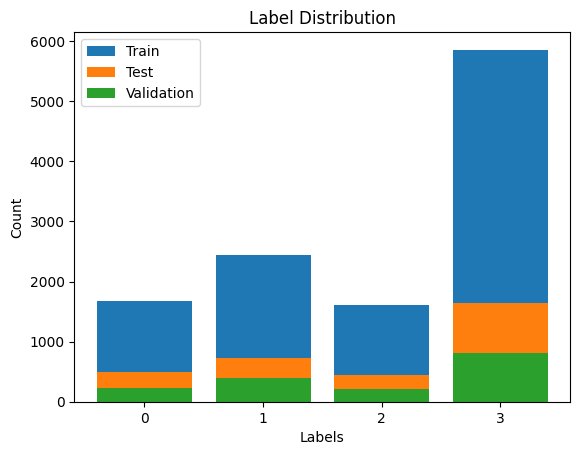

In [3]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [4]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [5]:
# Bidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.hidden_size = hidden_size
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential()

        for i in range(len(layer_sizes)-1):
            self.mlp.add_module(f'fc{i+1}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        return self.mlp(x)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0376, Val Loss: 0.0445
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0403, Val Loss: 0.0371
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0262, Val Loss: 0.0254
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0171, Val Loss: 0.0176
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0160, Val Loss: 0.0179
ES_Counter: 1
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0182, Val Loss: 0.0143
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0173, Val Loss: 0.0131
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0110, Val Loss: 0.0130
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0128, Val Loss: 0.0120
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0096, Val Loss: 0.0115
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0094, Val Loss: 0.0112
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0131, Val Loss: 0.0104
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0087, Val Loss: 0.0116
ES_Counter: 1
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0134, Val Loss: 0.0106
ES_Counter: 2
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0087, Val Loss: 0.0089
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0116, Val Loss: 0.0092
ES_Counter: 1
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0130, Val Loss: 0.0090
ES_Counter: 2
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0074, Val Loss: 0.0087
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0106, Val Loss: 0.0086
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0075, Val Loss: 0.0081
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0088, Val Loss: 0.0081
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0086, Val Loss: 0.0077
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0070, Val Loss: 0.0079
ES_Counter: 1
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0076, Val Loss: 0.0074
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0077, Val Loss: 0.0074
ES_Counter: 1
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0071, Val Loss: 0.0075
ES_Counter: 2
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0074, Val Loss: 0.0076
ES_Counter: 3
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0073, Val Loss: 0.0070
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0087, Val Loss: 0.0070
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0086, Val Loss: 0.0069
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0064, Val Loss: 0.0067
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0074, Val Loss: 0.0063
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0092, Val Loss: 0.0072
ES_Counter: 1
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0065, Val Loss: 0.0067
ES_Counter: 2
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0078, Val Loss: 0.0073
ES_Counter: 3
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0071, Val Loss: 0.0063
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0056, Val Loss: 0.0065
ES_Counter: 1
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0066, Val Loss: 0.0062
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0076, Val Loss: 0.0062
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0048, Val Loss: 0.0059
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0062, Val Loss: 0.0061
ES_Counter: 1
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0087, Val Loss: 0.0063
ES_Counter: 2
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0079, Val Loss: 0.0061
ES_Counter: 3
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0067, Val Loss: 0.0065
ES_Counter: 4
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0054, Val Loss: 0.0059
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0066, Val Loss: 0.0062
ES_Counter: 1
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0060, Val Loss: 0.0057
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0075, Val Loss: 0.0058
ES_Counter: 1
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0055, Val Loss: 0.0056
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0055, Val Loss: 0.0058
ES_Counter: 1


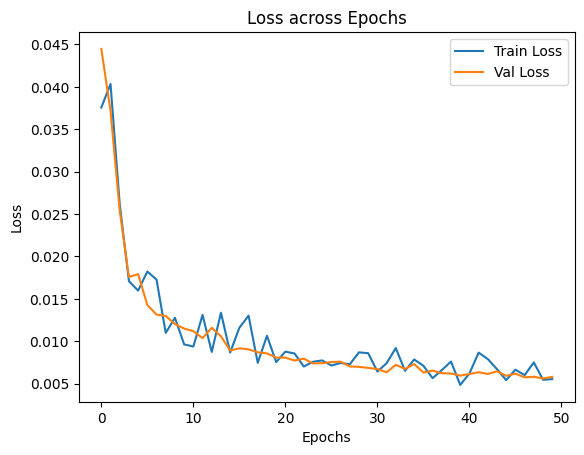

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])


In [8]:
tag = '1CNN_1LSTMBD'
encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'
train_losses, val_losses = train_model(Autoencoder, train_dataloader, val_dataloader, val_dataset, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
plot_loss_graph(train_losses, val_losses, tag)
encoded_data, labels = encode_data(train_dataloader, dataset_ver, tag, encoder_ver)

Training SVM Classifier...
Accuracy: 0.9628670120898101


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.83%


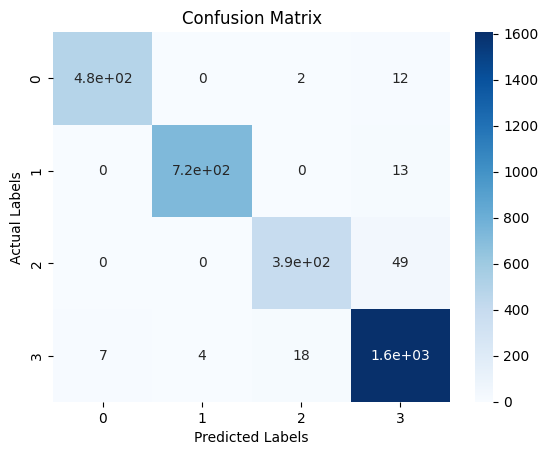

In [16]:
svm_classifier = train_svm(encoded_data, labels.ravel(), dataset_ver, tag, encoder_ver)
### Streamlined testing of model + SVM ###
test_labels, test_predictions = test_model(test_dataloader, dataset_ver, tag, encoder_ver)
calculate_accuracy(test_labels, test_predictions, tag)

In [9]:
enc_X_train, enc_X_val, enc_y_train, enc_y_val = train_test_split(encoded_data, labels, test_size=0.2, random_state=42)

print(f'{enc_X_train.shape=}, {enc_y_train.shape=}')
print(f'{enc_X_val.shape=}, {enc_y_val.shape=}')

encoded_dataset_train = TensorDataset(enc_X_train, enc_y_train)
encoded_dataloader_train = DataLoader(encoded_dataset_train, batch_size=1, shuffle=True)

encoded_dataset_val = TensorDataset(enc_X_val, enc_y_val)
encoded_dataloader_val = DataLoader(encoded_dataset_val, batch_size=1, shuffle=True)

enc_X_train.shape=torch.Size([9262, 360]), enc_y_train.shape=torch.Size([9262, 1])
enc_X_val.shape=torch.Size([2316, 360]), enc_y_val.shape=torch.Size([2316, 1])


In [12]:
def train_MLP(model, learning_rate, num_epochs, patience):
    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    best_val_acc = 0
    es_count = 0

    for epoch in range(num_epochs):
        if es_count < patience:
            print(f'Starting Epoch {epoch+1}...')
            model.train()

            train_preds = []
            train_labels = []

            correct_train = 0
            total_train = 0

            for train_X, train_y in tqdm(encoded_dataloader_train):
                optimizer.zero_grad()
                
                train_output = model(train_X)

                train_loss = criterion(train_output, train_y[0].type(torch.LongTensor))
                train_loss.backward()
                optimizer.step()

                train_preds.append(torch.argmax(train_output))
                train_labels.append(train_y)

                if train_preds[-1] == train_labels[-1]:
                    correct_train += 1
                total_train += 1
            
            train_losses.append(train_loss.item())
            print(f'Train Loss = {train_losses[-1]}')

            acc = (correct_train / total_train) * 100
            print(f'Accuracy = {acc}')

            model.eval()

            val_preds = []
            val_labels = []

            correct_val = 0
            total_val = 0

            for val_X, val_y in tqdm(encoded_dataloader_val):
                val_output = model(val_X)

                val_preds.append(torch.argmax(val_output))
                val_labels.append(val_y)

                if val_preds[-1] == val_labels[-1]:
                    correct_val += 1
                total_val += 1

            val_losses.append(criterion(val_output, val_y[0].type(torch.LongTensor)))
            print(f'Val Loss = {val_losses[-1]}')

            val_acc = (correct_val / total_val) * 100
            print(f'Val Acc = {val_acc}')

            if val_acc > best_val_acc:
                torch.save(deepcopy(model.state_dict()), 'ML_Models/noncausal_tcn_state_20e.pt')
                best_val_acc = val_acc
                es_count = 0
            
            es_count += 1
        
        else:
            print('Early Stopping...')

    return train_losses, val_losses

In [13]:
mlp_classifier_1 = MLP([360, 64, 16, 4])
print(mlp_classifier_1)
train_MLP(mlp_classifier_1, 1e-3, 50, 5)

Starting Epoch 1...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.13729529082775116
Accuracy = 90.76873245519326


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0019019624451175332
Val Acc = 90.28497409326425
Starting Epoch 2...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 5.388247013092041
Accuracy = 91.62167998272511


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0011822147062048316
Val Acc = 91.75302245250433
Starting Epoch 3...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.45253631472587585
Accuracy = 92.04275534441805


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.015730226412415504
Val Acc = 92.87564766839378
Starting Epoch 4...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.0
Accuracy = 92.71215720146837


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.038025692105293274
Val Acc = 92.61658031088082
Starting Epoch 5...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.0028208012226969004
Accuracy = 92.92809328438783


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.04414151981472969
Val Acc = 91.10535405872193
Starting Epoch 6...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.011489532887935638
Accuracy = 93.33837184193479


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.03488548472523689
Val Acc = 91.96891191709845
Starting Epoch 7...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.2042883336544037
Accuracy = 93.50032390412439


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.967792272567749
Val Acc = 91.40759930915371
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...


([0.13729529082775116,
  5.388247013092041,
  0.45253631472587585,
  0.0,
  0.0028208012226969004,
  0.011489532887935638,
  0.2042883336544037],
 [tensor(0.0019, grad_fn=<NllLossBackward0>),
  tensor(0.0012, grad_fn=<NllLossBackward0>),
  tensor(0.0157, grad_fn=<NllLossBackward0>),
  tensor(0.0380, grad_fn=<NllLossBackward0>),
  tensor(0.0441, grad_fn=<NllLossBackward0>),
  tensor(0.0349, grad_fn=<NllLossBackward0>),
  tensor(0.9678, grad_fn=<NllLossBackward0>)])

In [15]:
mlp_classifier_2 = MLP([360, 128, 32, 4])
print(mlp_classifier_2)
train_MLP(mlp_classifier_2, 1e-3, 50, 5)

MLP(
  (mlp): Sequential(
    (fc1): Linear(in_features=360, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=4, bias=True)
  )
)
Starting Epoch 1...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 4.5060096454108134e-05
Accuracy = 87.35694234506586


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0780562162399292
Val Acc = 90.19861830742659
Starting Epoch 2...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.003079555230215192
Accuracy = 90.82271647592313


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.10890872776508331
Val Acc = 90.5440414507772
Starting Epoch 3...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.13449613749980927
Accuracy = 91.53530554955734


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.00402105925604701
Val Acc = 89.2055267702936
Starting Epoch 4...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 7.748303323751315e-05
Accuracy = 92.28028503562945


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.007824130356311798
Val Acc = 91.83937823834198
Starting Epoch 5...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.007632853463292122
Accuracy = 92.62578276830058


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.2471831738948822
Val Acc = 90.84628670120898
Starting Epoch 6...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.022578082978725433
Accuracy = 92.75534441805226


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0022400543093681335
Val Acc = 91.79620034542314
Starting Epoch 7...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.16244135797023773
Accuracy = 93.0144677175556


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 7.867782187531702e-06
Val Acc = 93.00518134715026
Starting Epoch 8...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.15399838984012604
Accuracy = 93.11163895486936


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0033541631419211626
Val Acc = 93.35060449050087
Starting Epoch 9...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.0005310555570758879
Accuracy = 93.52191751241632


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.04143677279353142
Val Acc = 92.65975820379965
Starting Epoch 10...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.00010871296399272978
Accuracy = 93.45713668754048


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.015821870416402817
Val Acc = 92.53022452504318
Starting Epoch 11...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.009349019266664982
Accuracy = 93.81343122435759


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0031413515098392963
Val Acc = 93.09153713298791
Starting Epoch 12...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.30085182189941406
Accuracy = 94.01857050313107


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.003301291260868311
Val Acc = 93.99827288428325
Starting Epoch 13...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.011823456734418869
Accuracy = 94.2453033901965


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0002212279650848359
Val Acc = 92.87564766839378
Starting Epoch 14...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 1.9311717551317997e-05
Accuracy = 94.21291297775858


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 2.610649426060263e-05
Val Acc = 93.30742659758204
Starting Epoch 15...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.006294663064181805
Accuracy = 94.1265385445908


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 4.2676016164477915e-05
Val Acc = 93.69602763385146
Starting Epoch 16...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 1.0878255367279053
Accuracy = 94.4828330814079


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 4.168603420257568
Val Acc = 93.69602763385146
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...


([4.5060096454108134e-05,
  0.003079555230215192,
  0.13449613749980927,
  7.748303323751315e-05,
  0.007632853463292122,
  0.022578082978725433,
  0.16244135797023773,
  0.15399838984012604,
  0.0005310555570758879,
  0.00010871296399272978,
  0.009349019266664982,
  0.30085182189941406,
  0.011823456734418869,
  1.9311717551317997e-05,
  0.006294663064181805,
  1.0878255367279053],
 [tensor(0.0781, grad_fn=<NllLossBackward0>),
  tensor(0.1089, grad_fn=<NllLossBackward0>),
  tensor(0.0040, grad_fn=<NllLossBackward0>),
  tensor(0.0078, grad_fn=<NllLossBackward0>),
  tensor(0.2472, grad_fn=<NllLossBackward0>),
  tensor(0.0022, grad_fn=<NllLossBackward0>),
  tensor(7.8678e-06, grad_fn=<NllLossBackward0>),
  tensor(0.0034, grad_fn=<NllLossBackward0>),
  tensor(0.0414, grad_fn=<NllLossBackward0>),
  tensor(0.0158, grad_fn=<NllLossBackward0>),
  tensor(0.0031, grad_fn=<NllLossBackward0>),
  tensor(0.0033, grad_fn=<NllLossBackward0>),
  tensor(0.0002, grad_fn=<NllLossBackward0>),
  tensor(2.

In [17]:
mlp_classifier_3 = MLP([360, 64, 4])
print(mlp_classifier_3)
train_MLP(mlp_classifier_3, 1e-3, 50, 5)

MLP(
  (mlp): Sequential(
    (fc1): Linear(in_features=360, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
)
Starting Epoch 1...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.00659586489200592
Accuracy = 87.05463182897863


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0356241837143898
Val Acc = 90.50086355785838
Starting Epoch 2...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.38634607195854187
Accuracy = 90.91988771323688


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.4518490135669708
Val Acc = 91.58031088082902
Starting Epoch 3...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.008841532282531261
Accuracy = 91.8268192614986


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.010787269100546837
Val Acc = 90.75993091537133
Starting Epoch 4...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.004285319708287716
Accuracy = 92.61498596415461


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 9.894321920000948e-06
Val Acc = 91.01899827288429
Starting Epoch 5...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.03504457324743271
Accuracy = 93.1764197797452


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.3146187663078308
Val Acc = 92.44386873920553
Starting Epoch 6...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.0004633783537428826
Accuracy = 93.14402936730728


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0001951265730895102
Val Acc = 92.48704663212435
Starting Epoch 7...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.00014828535495325923
Accuracy = 93.81343122435759


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.006940068677067757
Val Acc = 91.58031088082902
Starting Epoch 8...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.00011872540198964998
Accuracy = 93.99697689483912


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.017589764669537544
Val Acc = 93.9119170984456
Starting Epoch 9...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 5.1616290875244886e-05
Accuracy = 93.92139926581731


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.9642837047576904
Val Acc = 92.83246977547496
Starting Epoch 10...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.0007312007946893573
Accuracy = 93.94299287410927


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.0725947916507721
Val Acc = 93.13471502590673
Starting Epoch 11...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.07198619842529297
Accuracy = 94.25610019434248


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 1.9676002264022827
Val Acc = 93.43696027633851
Starting Epoch 12...


  0%|          | 0/9262 [00:00<?, ?it/s]

Train Loss = 0.06259958446025848
Accuracy = 94.47203627726194


  0%|          | 0/2316 [00:00<?, ?it/s]

Val Loss = 0.002272168407216668
Val Acc = 93.65284974093264
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...
Early Stopping...


([0.00659586489200592,
  0.38634607195854187,
  0.008841532282531261,
  0.004285319708287716,
  0.03504457324743271,
  0.0004633783537428826,
  0.00014828535495325923,
  0.00011872540198964998,
  5.1616290875244886e-05,
  0.0007312007946893573,
  0.07198619842529297,
  0.06259958446025848],
 [tensor(0.0356, grad_fn=<NllLossBackward0>),
  tensor(0.4518, grad_fn=<NllLossBackward0>),
  tensor(0.0108, grad_fn=<NllLossBackward0>),
  tensor(9.8943e-06, grad_fn=<NllLossBackward0>),
  tensor(0.3146, grad_fn=<NllLossBackward0>),
  tensor(0.0002, grad_fn=<NllLossBackward0>),
  tensor(0.0069, grad_fn=<NllLossBackward0>),
  tensor(0.0176, grad_fn=<NllLossBackward0>),
  tensor(0.9643, grad_fn=<NllLossBackward0>),
  tensor(0.0726, grad_fn=<NllLossBackward0>),
  tensor(1.9676, grad_fn=<NllLossBackward0>),
  tensor(0.0023, grad_fn=<NllLossBackward0>)])